## Running window MSD vs tau fit for trackID 195 with window size 20

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
from math import ceil

In [3]:
# Required constants
um_per_pixel = 0.117
s_per_frame = 2
# Example: Load your data, scale it, and then plot
dtype_dict = {
    "t": "float64",
    "x": "float64",
    "y": "float64",
    "trackID": "Int64",
}
# csv_file_path = r'Z:\Bisal_Halder_turbo\PROCESSED_DATA\Impact_of_cytoskeleton_on_HOPS_condensates\no_drug\Analysed Data\2x\Trackmate analysis new 07052024\alpha, D and step sizes_w20\20240118_UGD-2x-2s-replicate1-FOV-2_processed_step_size_w20.csv'
csv_file_path = "/Volumes/lsa-nwalter/Bisal_Halder_turbo/PROCESSED_DATA/Impact_of_cytoskeleton_on_HOPS_condensates/no_drug/Analysed Data/2x/Trackmate analysis new 07052024/alpha, D and step sizes_w20/20240118_UGD-2x-2s-replicate1-FOV-2_processed_step_size_w20.csv"
df = pd.read_csv(csv_file_path, dtype=dtype_dict)
df = df.dropna(subset=["t", "x", "y"])
df["trackID"] = pd.to_numeric(df["trackID"], errors="coerce").astype("Int64")
df = df.dropna(subset=["trackID"])
df["t"] *= s_per_frame
df["x"] *= um_per_pixel
df["y"] *= um_per_pixel

# Specify the trackID of interest
track_id_of_interest = 195

In [4]:
def calc_MSD_NonPhysUnit(track_data, lags):
    """
    Calculate the Mean Squared Displacement (MSD) for given lags.
    """
    Xs = track_data["x"].to_numpy()
    Ys = track_data["y"].to_numpy()

    MSDs = []
    for lag in lags:
        displacements = (Xs[:-lag] - Xs[lag:]) ** 2 + (Ys[:-lag] - Ys[lag:]) ** 2
        valid_displacements = displacements[~np.isnan(displacements)]
        MSD = np.nanmean(valid_displacements)
        MSDs.append(MSD)

    return np.array(MSDs, dtype=float)

In [88]:
def plot_MSD_vs_tau_for_trackID(df, track_id, window_size):
    """
    Plots log(MSD) vs. log(tau) for a specific trackID
    with window intervals and fitting information in the legend.
    """
    # Filter for the specific trackID
    df_track = df[df["trackID"] == track_id].copy()

    # Calculate MSD for each window for this track
    step_size = 1
    all_window_msds = []

    for start in range(0, len(df_track) - window_size + 1, step_size):
        end = start + window_size
        df_window = df_track.iloc[start:end]

        number_lag = ceil(window_size / 2)
        if number_lag < 3:
            number_lag = 3
        window_msd = calc_MSD_NonPhysUnit(df_window, np.arange(1, number_lag + 1))
        middle_time = df_window.iloc[ceil((window_size - 1) / 2)]["t"]
        all_window_msds.append(
            (window_msd, df_window.iloc[0]["t"], df_window.iloc[-1]["t"], middle_time)
        )

    # Generate a plot for each window
    lst_t = []
    lst_D_linear = []
    lst_D_loglog = []
    lst_alpha = []
    for i, (window_msd, start_time, end_time, middle_time) in enumerate(
        all_window_msds
    ):
        tau = np.arange(1, len(window_msd) + 1) * s_per_frame

        # Ensure only positive MSDs are used for log calculations
        valid_indices = window_msd > 0
        valid_taus = tau[valid_indices]
        valid_window_msd = window_msd[valid_indices]

        if len(valid_window_msd) < 2:
            continue  # Skip this plot if insufficient data for regression

        log_tau = np.log10(valid_taus)
        log_msd = np.log10(valid_window_msd)

        # Perform linear regression on log-log data
        slope, intercept, r_value, _, _ = linregress(log_tau, log_msd)
        D_loglog = (1 / 4) * 10**intercept

        # Perform linear regression on linear data
        slope_linear, intercept_linear, R_linear, P, std_err = linregress(
            valid_taus, valid_window_msd
        )
        D_linear = slope_linear / (8 / 3)  # um^2/s

        lst_t.append(middle_time)
        lst_D_linear.append(D_linear)
        lst_D_loglog.append(D_loglog)
        lst_alpha.append(slope)

        # Plotting
        # plt.figure()
        # plt.scatter(tau, window_msd, label='MSD Data')
        # fitted_line = 10**(intercept + slope * log_tau)
        # plt.plot(valid_taus, fitted_line, color='red',
        #          label=f'Fit: alpha={slope:.2f}, D={diffusion_coefficient:.2e}\n'
        #                f'R²={r_squared:.2f}, Mid Time={middle_time:.2f}s')
        # plt.xlabel('log tau')
        # plt.ylabel('log MSD')
        # plt.title(f'MSD vs. Tau for TrackID {track_id} ({start_time:.2f}s - {end_time:.2f}s)')
        # plt.xscale('log')
        # plt.yscale('log')
        # plt.legend()
        # plt.show()
    return lst_t, lst_D_linear, lst_D_loglog, lst_alpha


def quick_plot(lst_t, lst_D_linear, lst_D_loglog, lst_alpha):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 4), sharex=True)
    ax1.plot(lst_t, lst_D_linear, ls="-", c="blue")
    ax1.set_xlim(np.min(lst_t), np.max(lst_t))
    ax1.set_ylabel(r"D$_{linear}$")
    ax1.set_title("")
    ax1.grid(True)
    ax2.plot(lst_t, lst_D_loglog, ls="-", c="orange")
    ax2.set_ylabel(r"D$_{loglog}$")
    ax2.set_title("")
    ax2.grid(True)
    ax3.plot(lst_t, lst_alpha, ls="-", c="red")
    ax3.set_xlabel("t")
    ax3.set_ylabel("Alpha")
    ax3.set_title("")
    ax3.grid(True)
    plt.tight_layout()
    plt.show()

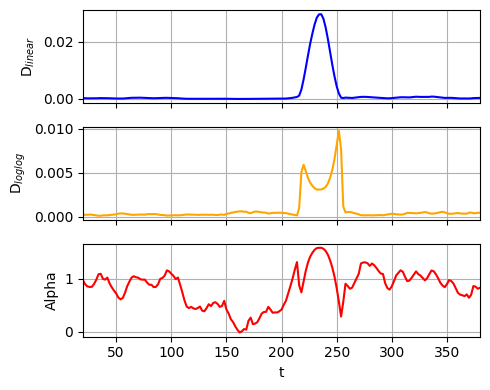

In [89]:
window_size = 20  # Adjust the window size as needed
lst_t, lst_D_linear, lst_D_loglog, lst_alpha = plot_MSD_vs_tau_for_trackID(df, track_id_of_interest, window_size)
quick_plot(lst_t, lst_D_linear, lst_D_loglog, lst_alpha)

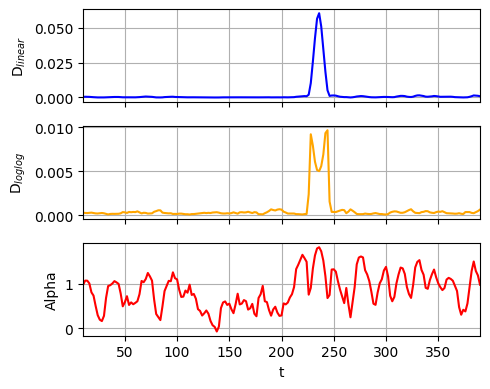

In [90]:
window_size = 10  # Adjust the window size as needed
lst_t, lst_D_linear, lst_D_loglog, lst_alpha = plot_MSD_vs_tau_for_trackID(df, track_id_of_interest, window_size)
quick_plot(lst_t, lst_D_linear, lst_D_loglog, lst_alpha)

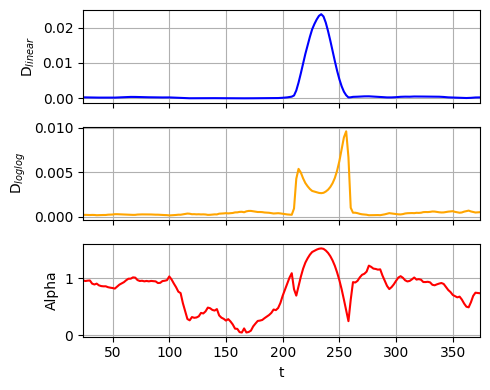

In [91]:
window_size = 25  # Adjust the window size as needed
lst_t, lst_D_linear, lst_D_loglog, lst_alpha = plot_MSD_vs_tau_for_trackID(df, track_id_of_interest, window_size)
quick_plot(lst_t, lst_D_linear, lst_D_loglog, lst_alpha)